<h1>Trying Ensemble of EfficientNet V2 (S, b1 and b2) models combining it with NN model for tabular data and fully connecting them. <br><br> Still experimenting with different augmentations, model architecture and learning rate schedule, and possibly hyper-parameters tuning. <br><br>Any suggestions and comments are more than welcome!  :) </h1>

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 

2024-04-23 22:58:57.979618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 22:58:57.979763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 22:58:58.116419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_s_imagenet"  # Name of pretrained classifier
    image_size = [224, 224]  # Input image size
    epochs = 10 # Training epochs
    batch_size = 256  # Batch size
    lr_mode = "step" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    num_folds = 10 # Number of folds to split the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['X4_mean', 'X11_mean', 'X18_mean',
                   'X26_mean', 'X50_mean', 'X3112_mean',]
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
    num_classes = len(class_names)
    aux_num_classes = len(aux_class_names)

In [3]:
keras.utils.set_random_seed(CFG.seed)

In [4]:
BASE_PATH = "/kaggle/input/planttraits2024"

In [5]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images/'+df['id'].astype(str)+'.jpeg'
df.loc[:, CFG.aux_class_names] = df.loc[:, CFG.aux_class_names].fillna(-1)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images/'+test_df['id'].astype(str)+'.jpeg'
FEATURE_COLS = test_df.columns[1:-1].tolist()
display(test_df.head(2))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,/kaggle/input/planttraits2024/train_images/192...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,/kaggle/input/planttraits2024/train_images/195...


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,image_path
0,201238668,8.086756,2246.500000,127.321426,20.423418,353.381042,17.535713,80,109,90,...,0.389460,0.387536,0.374910,0.363712,0.364623,0.379435,0.388294,0.398887,0.397853,/kaggle/input/planttraits2024/test_images/2012...
1,202310319,10.844286,495.871429,28.023809,18.738306,786.554382,29.292856,130,155,142,...,0.300813,0.332776,0.314386,0.291168,0.280947,0.277623,0.276503,0.271212,0.272672,/kaggle/input/planttraits2024/test_images/2023...


In [6]:
df_filter = df[(df['X4_mean'] > 0) &
                        (df['X11_mean'] < 200) & 
                        (df['X18_mean'] < 70) & 
                        (df['X50_mean'] < 200) & 
                        (df['X26_mean'] < 25000) &                            
                        (df['X3112_mean'] < 300000)]

In [7]:
df_filter.shape

(55183, 177)

In [8]:
from sklearn.feature_selection import SelectKBest, f_regression

kbest_features = set()
for target_col in CFG.class_names:
    print(f"Selecting top 10 features for target column: {target_col}")
    
    selector = SelectKBest(score_func=f_regression, k=10)
    X_selected = selector.fit_transform(df_filter[FEATURE_COLS].values, df_filter[target_col].values)

    selected_indices = selector.get_support(indices=True)
    
    selected_features = df_filter.columns[selected_indices]

    kbest_features.update(selected_features)
    print("Selected features:", selected_features)
    print()

Selecting top 10 features for target column: X4_mean
Selected features: Index(['id', 'WORLDCLIM_BIO15_precipitation_seasonality',
       'SOIL_sand_60.100cm_mean_0.01_deg', 'SOIL_silt_0.5cm_mean_0.01_deg',
       'SOIL_silt_100.200cm_mean_0.01_deg', 'SOIL_silt_15.30cm_mean_0.01_deg',
       'SOIL_silt_30.60cm_mean_0.01_deg', 'SOIL_silt_5.15cm_mean_0.01_deg',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2'],
      dtype='object')

Selecting top 10 features for target column: X11_mean
Selected features: Index(['SOIL_clay_60.100cm_mean_0.01_deg', 'SOIL_phh2o_60.100cm_mean_0.01_deg',
       'SOIL_sand_100.200cm_mean_0.01_deg', 'SOIL_sand_30.60cm_mean_0.01_deg',
       'SOIL_sand_60.100cm_mean_0.01_deg', 'SOIL_silt_0.5cm_mean_0.01_deg',
       'SOIL_silt_100.200cm_mean_0.01_deg', 'SOIL_silt_15.30cm_mean_0.01_deg',
       'SOIL_silt_30.60cm_mean_0.01_deg', 'SOIL_silt_5.15cm_mean_0.01_de

In [9]:
kbest_features = list(kbest_features)

In [10]:
kbest_features.remove('id')

In [11]:
kbest_features

['MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m9',
 'WORLDCLIM_BIO12_annual_precipitation',
 'SOIL_silt_100.200cm_mean_0.01_deg',
 'SOIL_clay_60.100cm_mean_0.01_deg',
 'SOIL_phh2o_15.30cm_mean_0.01_deg',
 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1',
 'SOIL_sand_30.60cm_mean_0.01_deg',
 'SOIL_cfvo_60.100cm_mean_0.01_deg',
 'SOIL_phh2o_5.15cm_mean_0.01_deg',
 'SOIL_clay_5.15cm_mean_0.01_deg',
 'SOIL_silt_5.15cm_mean_0.01_deg',
 'WORLDCLIM_BIO1_annual_mean_temperature',
 'SOIL_phh2o_30.60cm_mean_0.01_deg',
 'SOIL_clay_0.5cm_mean_0.01_deg',
 'SOIL_sand_100.200cm_mean_0.01_deg',
 'SOIL_phh2o_60.100cm_mean_0.01_deg',
 'SOIL_phh2o_0.5cm_mean_0.01_deg',
 'WORLDCLIM_BIO4_temperature_seasonality',
 'SOIL_clay_15.30cm_mean_0.01_deg',
 'SOIL_silt_0.5cm_mean_0.01_deg',
 'SOIL_phh2o_100.200cm_mean_0.01_deg',
 'SOIL_sand_60.100cm_mean_0.01_deg',
 'SOIL_silt_15.30cm_mean_0.01_deg',
 '

In [12]:
# import random
# def safe_augmentation(image, **kwargs):
#     # Apply random augmentation with safety checks
    
#     # Define a maximum number of attempts to generate a valid augmentation
#     max_attempts = 5
#     attempt = 0
    
#     while attempt < max_attempts:
#         # Attempt to apply augmentation
#         try:
#             augmented_image = keras_cv.layers.Augmenter(**kwargs)(image)
            
#             # Check if the augmented image contains non-black pixels
#             if tf.reduce_max(augmented_image) > 0:
#                 return augmented_image
#         except:
#             pass
        
#         # Increment attempt counter
#         attempt += 1
    
#     # If no valid augmentation is found, return the original image
#     return image

def build_augmenter():
    # Define augmentations with adjusted parameters
    aug_layers = [
        keras_cv.layers.RandomBrightness(factor=0.2, value_range=(0, 1)),
        keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
        keras_cv.layers.RandomShear(x_factor=(0.2, 0.8), y_factor=(0.2, 0.8)),
        keras_cv.layers.RandomSaturation(factor=(0.4, 0.6)),
        #keras_cv.layers.RandomHue(factor=0.1, value_range=(0, 0.05)),
        keras_cv.layers.RandomCutout(height_factor=(0.1, 0.2), width_factor=(0.1, 0.2)),
        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
        keras_cv.layers.RandomZoom(height_factor=(0.1, 0.2)),
        keras_cv.layers.RandomRotation(factor=(0.05, 0.1)),
        keras_cv.layers.RandomColorDegeneration(factor=(0.05, 0.1)),
        keras_cv.layers.RandAugment(value_range=(0, 1)),
        keras_cv.layers.RandomChannelShift(value_range=(0, 1),factor=0.5)
    ]
        # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    
    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    return augment
    
#     # Apply augmentations to random samples
#     def augment(inp, label):
#         images = inp["images"]
        
#         # Randomly select augmentation layer with adjusted parameters
#         selected_augmentation = random.choice(aug_layers)
        
#         # Apply selected augmentation with safety checks
#         images = safe_augmentation(images, **selected_augmentation)
        
#         inp["images"] = images
#         return inp, label
    
#    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        path = inp["images"]
        
        # Read jpeg image
        file_bytes = tf.io.read_file(path)
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, labels=None):
        inp = decode_image(inp)
        label = decode_label(labels[0], CFG.num_classes)
        aux_label = decode_label(labels[1], CFG.aux_num_classes)
        return (inp, (label, aux_label))

    return decode_with_labels if with_labels else decode_image


def build_dataset(
    paths,
    features,
    labels=None,
    aux_labels=None,
    batch_size=32,
    cache=True,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    repeat=True,
    shuffle=1024,
    cache_dir="",
    drop_remainder=False,
):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None or aux_labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    inp = {"images": paths, "features": features}
    slices = (inp, (labels, aux_labels)) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [13]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(CFG.class_names):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(df_filter[trait], np.linspace(0, 100, CFG.num_folds + 1))
    df_filter[f"bin_{i}"] = np.digitize(df_filter[trait], bin_edges)

# Concatenate the bins into a final bin
df_filter["final_bin"] = (
    df_filter[[f"bin_{i}" for i in range(len(CFG.class_names))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
df_filter = df_filter.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(df_filter, df_filter["final_bin"])):
    df_filter.loc[valid_idx, "fold"] = fold

/tmp/ipykernel_34/3139742102.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter[f"bin_{i}"] = np.digitize(df_filter[trait], bin_edges)
/tmp/ipykernel_34/3139742102.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter[f"bin_{i}"] = np.digitize(df_filter[trait], bin_edges)
/tmp/ipykernel_34/3139742102.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [14]:
from sklearn.preprocessing import StandardScaler

# Sample from full data
sample_df = df_filter.copy()
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[kbest_features].values)
valid_features = scaler.transform(valid_df[kbest_features].values)

# Train
train_paths = train_df.image_path.values
train_labels = train_df[CFG.class_names].values
train_aux_labels = train_df[CFG.aux_class_names].values
train_ds = build_dataset(train_paths, train_features, train_labels, train_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=False)

# Valid
valid_paths = valid_df.image_path.values
valid_labels = valid_df[CFG.class_names].values
valid_aux_labels = valid_df[CFG.aux_class_names].values
valid_ds = build_dataset(valid_paths, valid_features, valid_labels, valid_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

# Num Train: 49664 | Num Valid: 5519


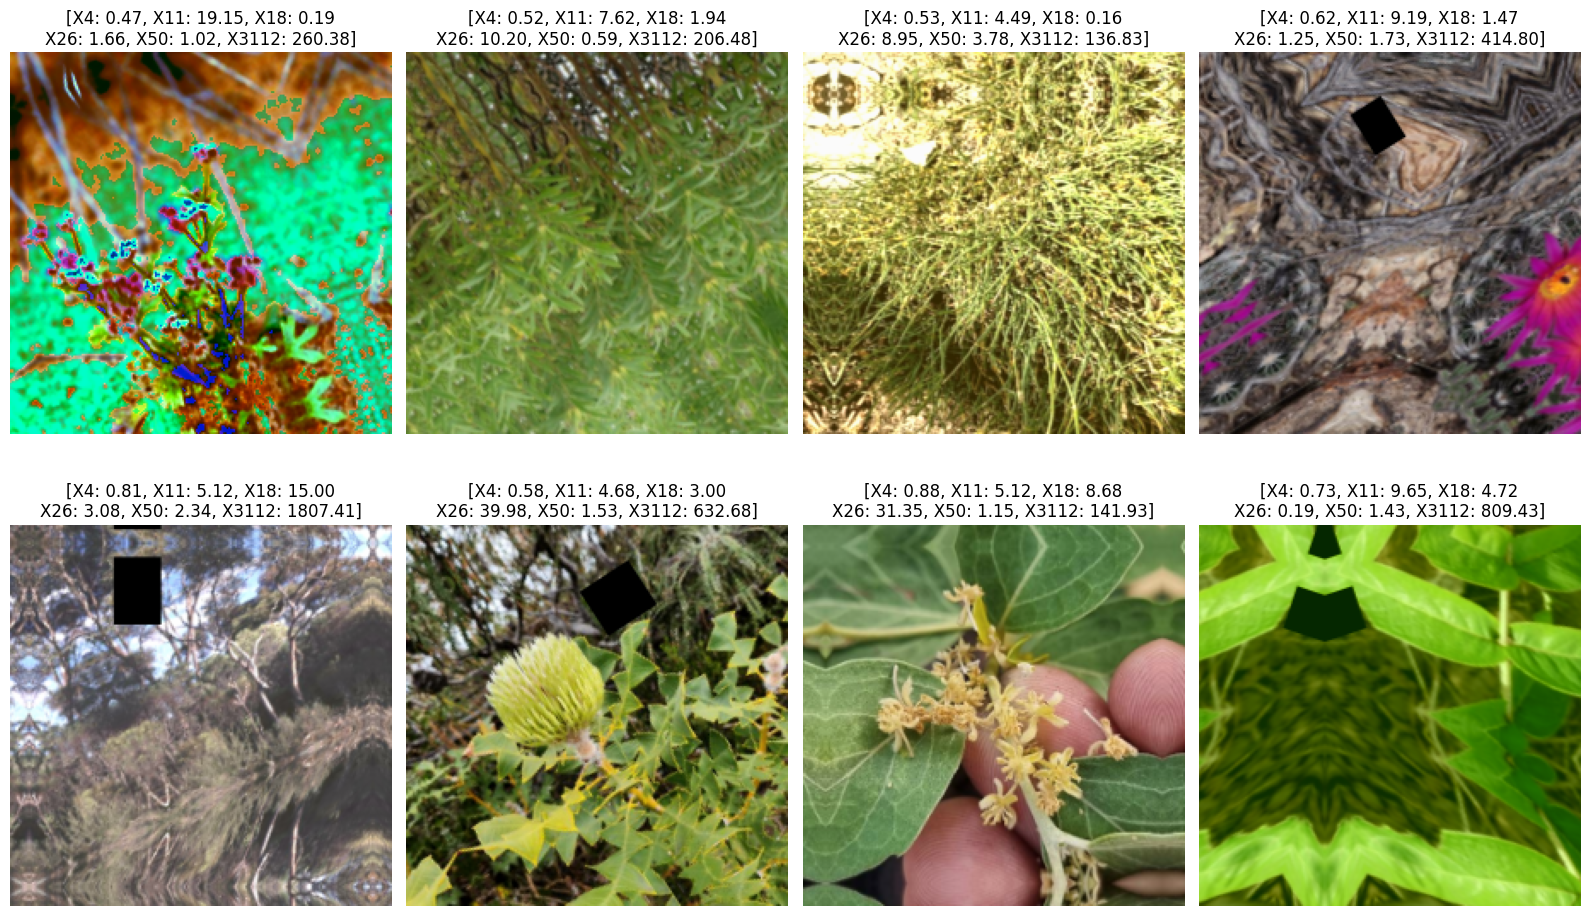

In [15]:
inps, tars = next(iter(train_ds))
imgs = inps["images"]
num_imgs, num_cols = 8, 4

plt.figure(figsize=(4 * num_cols, num_imgs // num_cols * 5))
for i, (img, tar) in enumerate(zip(imgs[num_imgs:num_imgs+num_imgs], tars[0][num_imgs:num_imgs+num_imgs])):
    plt.subplot(num_imgs // num_cols, num_cols, i + 1)
    img = img. numpy()
    tar = tar.numpy()
    
    img = (img - img.min()) / (img.max() + 1e-4)

    formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(CFG.class_names[j : j + 3], tar[j : j + 3])
            )
            for j in range(0, len(CFG.class_names), 3)
        ]
    )

    plt.imshow(img)
    plt.title(f"[{formatted_tar}]")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
class R2Loss(keras.losses.Loss):
    def __init__(self, use_mask=False, name="r2_loss"):
        super().__init__(name=name)
        self.use_mask = use_mask

    def call(self, y_true, y_pred):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = ops.where(mask, y_true, 0.0)
            y_pred = ops.where(mask, y_pred, 0.0)
        SS_res = ops.sum(ops.square(y_true - y_pred), axis=0)  # (B, C) -> (C,)
        SS_tot = ops.sum(ops.square(y_true - ops.mean(y_true, axis=0)), axis=0)  # (B, C) -> (C,)
        r2_loss = SS_res / (SS_tot + 1e-6)  # (C,)
        return ops.mean(r2_loss)  # ()
    
class R2Metric(keras.metrics.Metric):
    def __init__(self, name="r2", **kwargs):
        super(R2Metric, self).__init__(name=name, **kwargs)
        self.SS_res = self.add_weight(name='SS_res', shape=(6,), initializer='zeros')
        self.SS_tot = self.add_weight(name='SS_tot', shape=(6,) ,initializer='zeros')
        self.num_samples = self.add_weight(name='num_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        SS_res = ops.sum(ops.square(y_true - y_pred), axis=0)
        SS_tot = ops.sum(ops.square(y_true - ops.mean(y_true, axis=0)), axis=0)
        self.SS_res.assign_add(SS_res)
        self.SS_tot.assign_add(SS_tot)
        self.num_samples.assign_add(ops.cast(ops.shape(y_true)[0], "float32"))

    def result(self):
        r2 = 1 - self.SS_res / (self.SS_tot + 1e-6)
        return ops.mean(r2)

    def reset_states(self):
        self.total_SS_res.assign(0)
        self.total_SS_tot.assign(0)
        self.num_samples.assign(0)

In [17]:
def build_model():
    # Define input layers
    img_input = keras.Input(shape=(*CFG.image_size, 3), name="images")
    feat_input = keras.Input(shape=(len(kbest_features),), name="features")
    
    # Define EfficientNetV2 models with different versions
    backbones = []
    for version in ['s', 'b2']:
        backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(f"efficientnetv2_{version}_imagenet")
        backbone.trainable = False  # Freeze weights of pre-trained models
        backbones.append(backbone)
        
    # ResNet backbone
    resnet_backbone = keras_cv.models.ResNetV2Backbone.from_preset("resnet50_v2_imagenet")
    resnet_backbone.trainable = False  # Freeze weights
    backbones.append(resnet_backbone)
    
    # Create branches for image input using different versions of EfficientNetV2
    x1_branches = []
    for i, backbone in enumerate(backbones):
        x1 = backbone(img_input)
        x1 = keras.layers.GlobalAveragePooling2D(name=f'global_avg_pool_{i}')(x1)
        x1_branches.append(x1)
    
    # Branch for tabular/feature input
    x2 = keras.layers.Dense(256, activation="relu")(feat_input)
    x2 = keras.layers.Dropout(0.2)(x2)
    x2 = keras.layers.Dense(64, activation="relu")(x2)
    
    # Concatenate outputs from image and feature branches
    concat = keras.layers.Concatenate()(x1_branches + [x2])
    
    # Fully connected layers
    x = keras.layers.Dense(512, activation="relu")(concat)
    x = keras.layers.Dropout(0.2)(x)
    
    # Output layers
    out1 = keras.layers.Dense(CFG.num_classes, activation="softmax", name="head")(x)
    out2 = keras.layers.Dense(CFG.aux_num_classes, activation="softmax", name="aux_head")(x)
    out = {"head": out1, "aux_head":out2}
    
    # Build model
    model = keras.models.Model([img_input, feat_input], out)
    
    return model

# Build the model
model = build_model()

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        "head": R2Loss(use_mask=False),
        "aux_head": R2Loss(use_mask=True),
    },
    loss_weights={"head": 1.0, "aux_head": 0.3},
    metrics={"head": R2Metric()}
)

# Model Summary
model.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/resnetv2/keras/resnet50_v2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/resnetv2/keras/resnet50_v2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/resnetv2/k

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ images (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      6,912 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_v2s_… │ (None, 7, 7,      │ 20,331,360 │ images[0][0]      │
│ (EfficientNetV2Bac… │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_v2b2… │ (None, 7, 7,      │  8,769,374 │ images[0][0]      │
│ (EfficientNetV2Bac… │ 1408)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_net50v2_backbo… │ (None, 7, 7,      │ 23,564,800 │ images[0][0]      │
│ (ResNetV2Backbone)  │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool_0   │ (None, 1280)      │          0 │ efficient_net_v2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool_1   │ (None, 1408)      │          0 │ efficient_net_v2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool_2   │ (None, 2048)      │          0 │ res_net50v2_back… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     16,448 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4800)      │          0 │ global_avg_pool_… │
│ (Concatenate)       │                   │            │ global_avg_pool_… │
│                     │                   │            │ global_avg_pool_… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  2,458,112 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_head (Dense)    │ (None, 6)         │      3,078 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head (Dense)        │ (None, 6)         │      3,078 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,153,162 (210.39 MB)

 Trainable params: 2,487,628 (9.49 MB)

 Non-trainable params: 52,665,534 (200.90 MB)

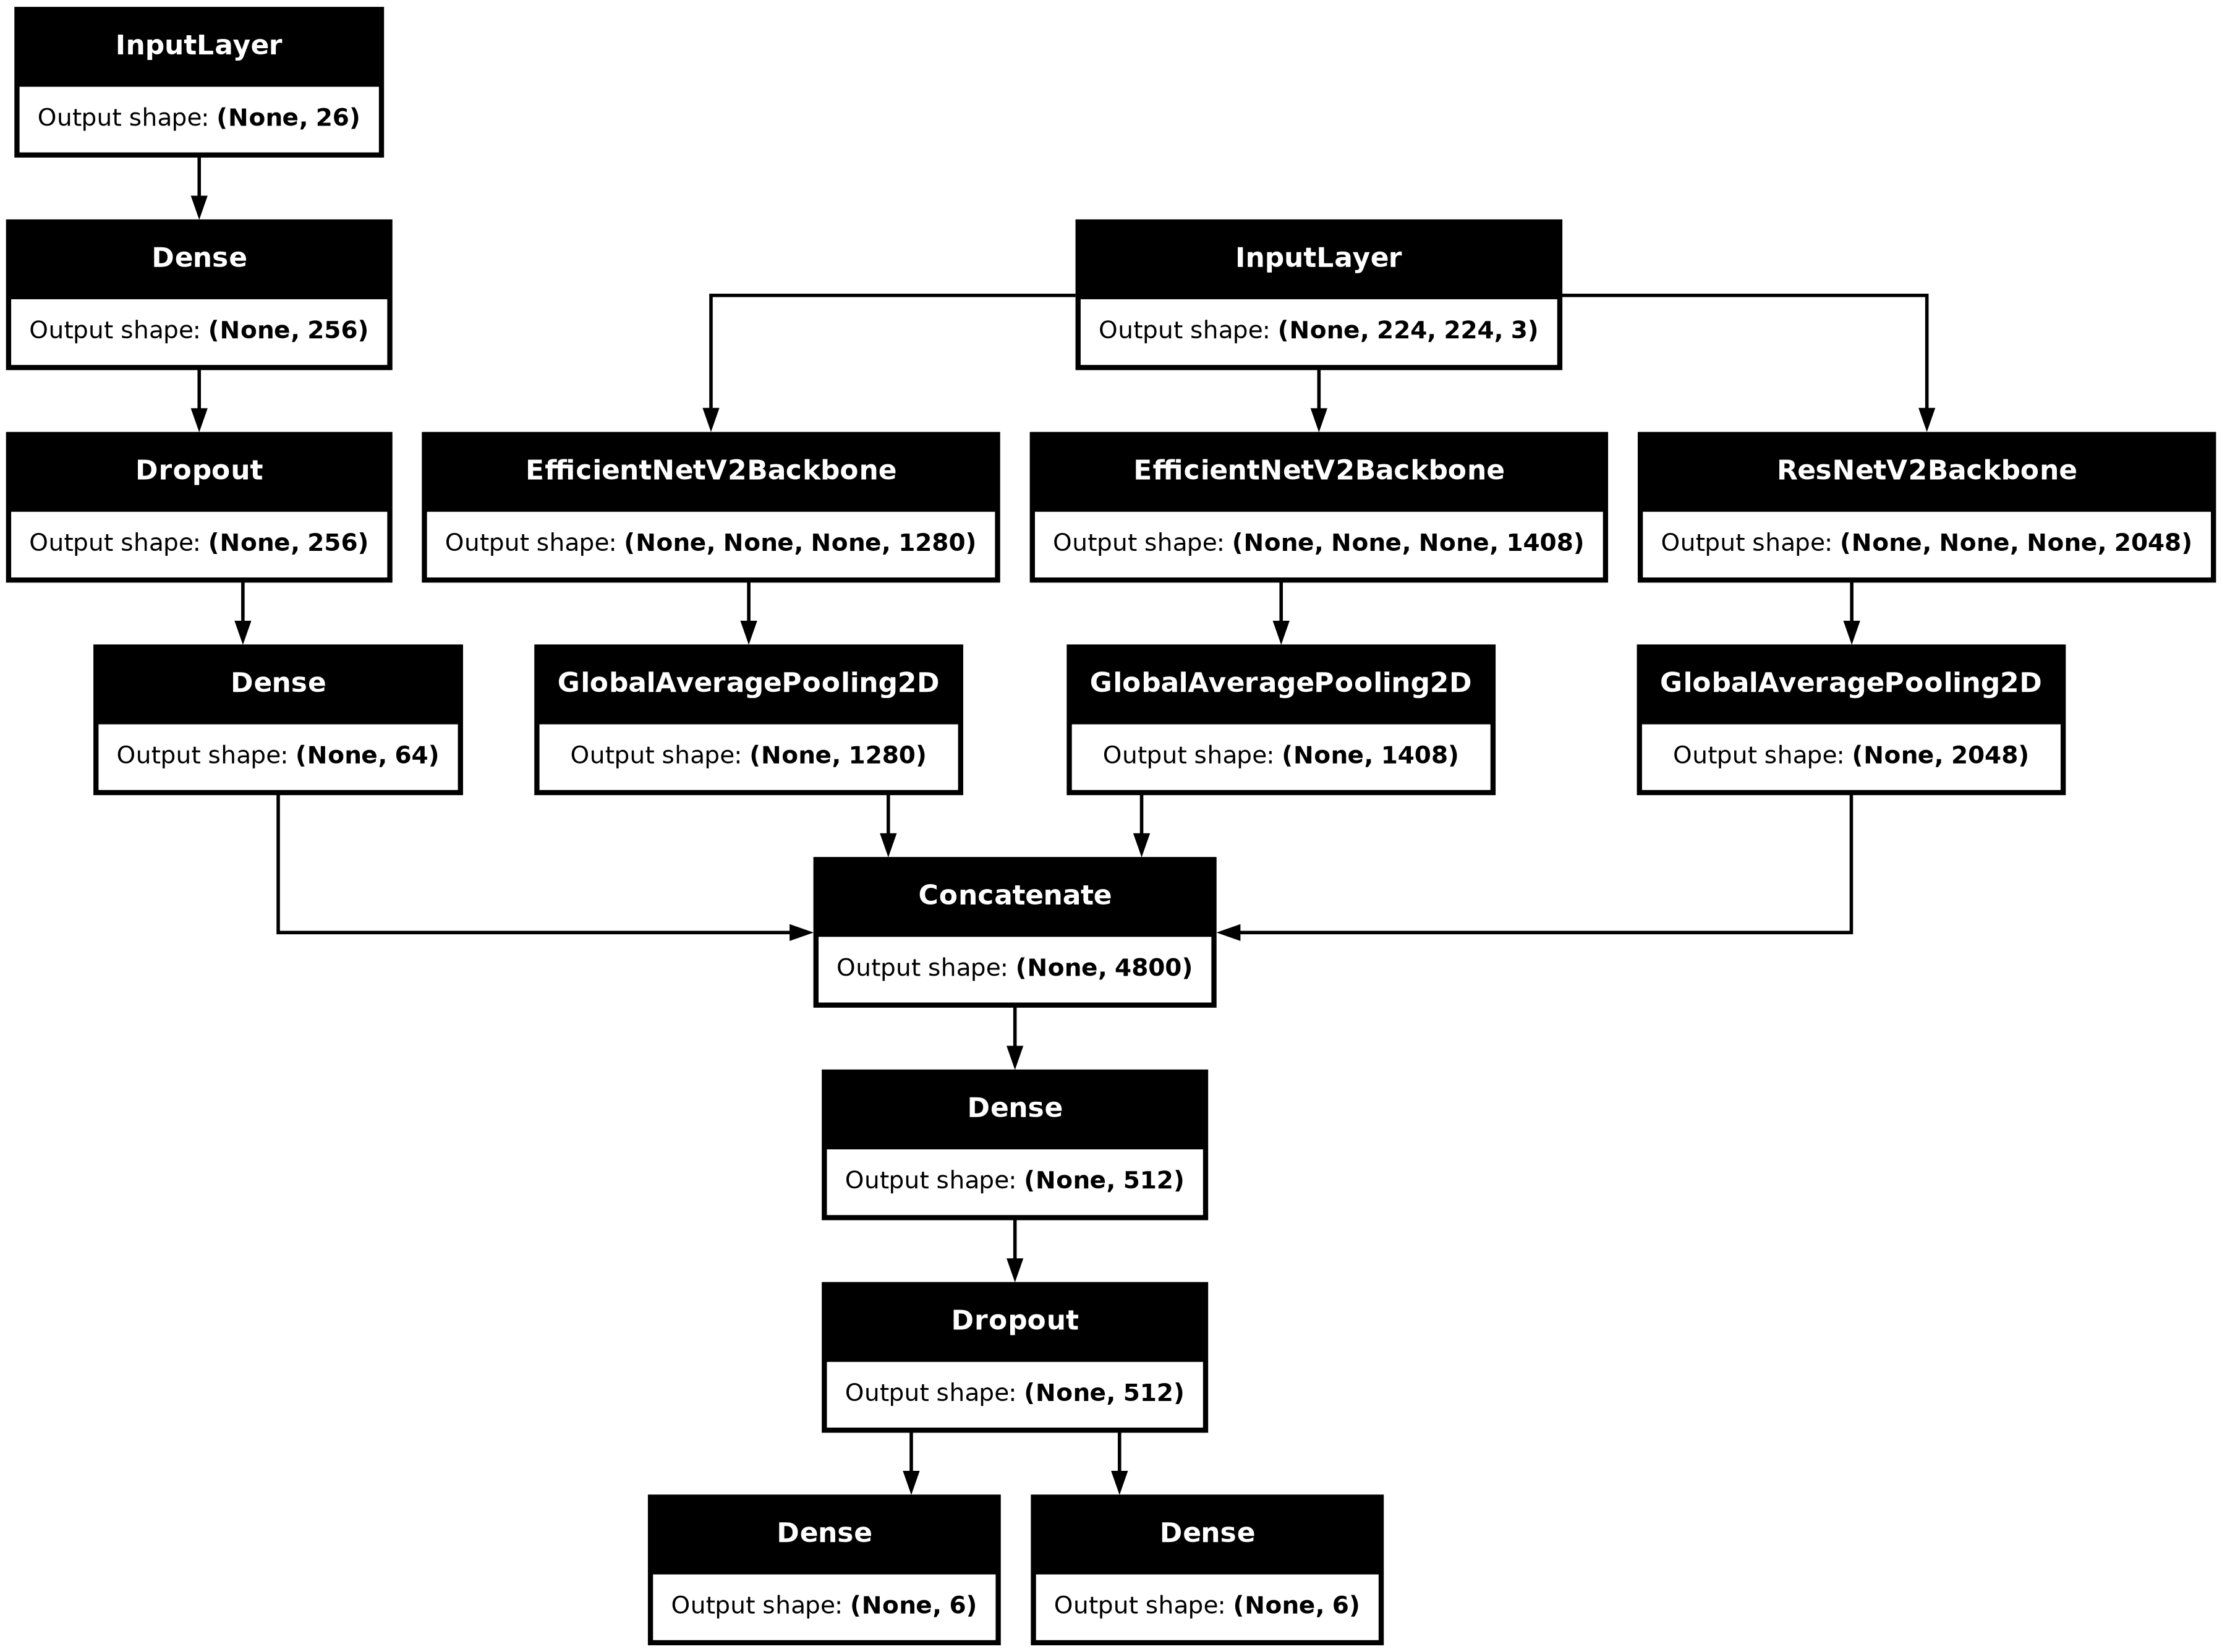

In [18]:
keras.utils.plot_model(model, show_shapes=True)

In [19]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-4, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

In [20]:
# import math

# def get_lr_callback(batch_size=10, mode='cos', epochs=10, plot=False):
#     initial_learning_rate = 0.5
# #     lr_start, lr_max, lr_min = 5e-4, 5e-4 * batch_size, 1e-5
# #     lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75
#     def lrfn(epoch):
#         k = 0.5
#         return initial_learning_rate * math.exp(-k*epoch)
# #     def lrfn(epoch):  # Learning rate update function
# #         if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
# #         elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
# #         elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
# #         elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
# #         elif mode == 'cos':
# #             decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
# #             phase = math.pi * decay_epoch_index / decay_total_epochs
# #             lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
# #         return lr

#     if plot:  # Plot lr curve if plot is True
#         plt.figure(figsize=(10, 5))
#         plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
#         plt.xlabel('Epoch'); plt.ylabel('Learning Rate')
#         plt.title('Learning Rate Scheduler')
#         plt.show()

#     return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

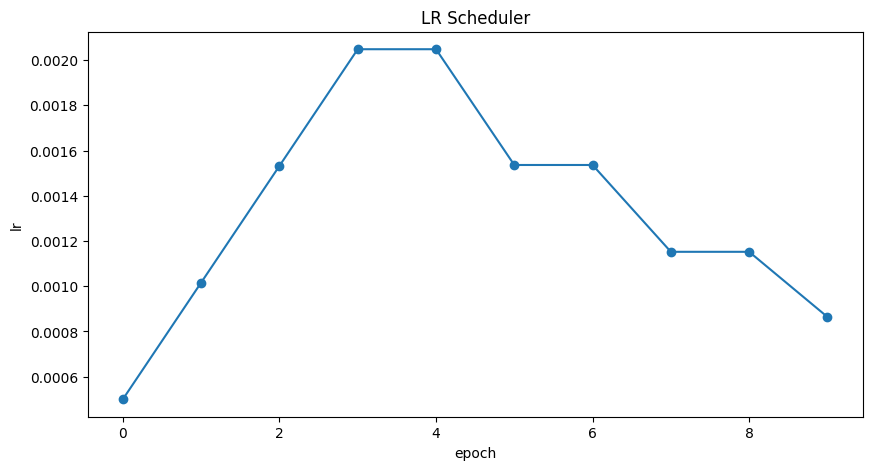

In [21]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

In [22]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_head_r2",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
)

In [23]:
#model.load_weights("/kaggle/input/efficientnetv2-ensemble-keras/best_model.keras")

In [24]:
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_data=valid_ds,
    verbose=CFG.verbose,
)

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1217s 6s/step - head_r2: -0.1210 - loss: 1.7777 - val_head_r2: -0.0966 - val_loss: 1.6953 - learning_rate: 5.0000e-04
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1033s 5s/step - head_r2: -0.0996 - loss: 1.7089 - val_head_r2: -0.0912 - val_loss: 1.6899 - learning_rate: 0.0010
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1032s 5s/step - head_r2: -0.0961 - loss: 1.7044 - val_head_r2: -0.0908 - val_loss: 1.6892 - learning_rate: 0.0015
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1037s 5s/step - head_r2: -0.0950 - loss: 1.7040 - val_head_r2: -0.0904 - val_loss: 1.6885 - learning_rate: 0.0020
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1024s 5s/step - head_r2: -0.0943 - loss: 1.7015 - val_head_r2: -0.0902 - val_loss: 1.6886 - learning_rate: 0.0020
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1048s 5s/step - head_r2: -0.0934 - loss: 1.7010 - val_head_r2: -0.0906 - val_loss: 1.6892 - learning_rate: 0.0015
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1036s 5s/step - head_r2: -0.0931

In [25]:
# Best Result
best_R2 = max(history.history['val_head_r2'])
best_Epoch = np.argmax(history.history['val_head_r2']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best R2: {best_R2:.5f}")
print(f"Best Epoch: {best_Epoch}")
print("#" * 28)

########## Result ##########
Best R2: -0.08878
Best Epoch: 9
############################


In [26]:
model.load_weights("best_model.keras")

In [27]:
# Test
test_paths = test_df.image_path.values
test_features = scaler.transform(test_df[kbest_features].values) 
test_ds = build_dataset(test_paths, test_features, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

In [29]:
preds = model.predict(test_ds)["head"]

2024-04-24 02:01:19.953786: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 154140672 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  147.00MiB
              constant allocation:         0B
        maybe_live_out allocation:  147.00MiB
     preallocated temp allocation:         0B
                 total allocation:  294.00MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 147.00MiB
		Entry Parameter Subshape: f32[256,224,224,3]

	Buffer 2:
		Size: 147.00MiB
		Operator: op_name="jit(fn)/jit(main)/add" source_file="/tmp/ipykernel_34/1818916297.py" source_line=1
		XLA Label: fusion
		Shape: f32[256,224,224,3]

	Buffer 3:
		Size: 4B
		Entry Parameter Subshape: f32[]




ValueError: Exception encountered when calling Rescaling.call().

[1mRESOURCE_EXHAUSTED: Out of memory while trying to allocate 154140672 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  147.00MiB
              constant allocation:         0B
        maybe_live_out allocation:  147.00MiB
     preallocated temp allocation:         0B
                 total allocation:  294.00MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 147.00MiB
		Entry Parameter Subshape: f32[256,224,224,3]
		==========================

	Buffer 2:
		Size: 147.00MiB
		Operator: op_name="jit(fn)/jit(main)/add" source_file="/tmp/ipykernel_34/1818916297.py" source_line=1
		XLA Label: fusion
		Shape: f32[256,224,224,3]
		==========================

	Buffer 3:
		Size: 4B
		Entry Parameter Subshape: f32[]
		==========================

[0m

Arguments received by Rescaling.call():
  • inputs=jnp.ndarray(shape=(256, 224, 224, 3), dtype=float32)

In [ ]:
pred_df = test_df[["id"]].copy()
target_cols = [x.replace("_mean","") for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["id"]].copy()
sub_df = sub_df.merge(pred_df, on="id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()